# import library

In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.linalg import Vector
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier, NaiveBayes, RandomForestClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml import Pipeline
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.ml.feature import StandardScaler

spark = SparkSession.builder.appName('classification').getOrCreate()

21/12/10 18:29:15 WARN Utils: Your hostname, SheepB resolves to a loopback address: 127.0.1.1; using 192.168.1.107 instead (on interface wlo1)
21/12/10 18:29:15 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/12/10 18:29:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
21/12/10 18:29:17 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


# Read data

In [2]:
df = spark.read.csv('Absenteeism_at_work.csv', inferSchema=True, header=True, sep=',')

In [3]:
df.limit(10).toPandas()

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,...,Disciplinary_failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism_time_in_hours
0,11,26,7,3,1,289,36,13,33,239.554,...,0,1,2,1,0,1,90,172,30,4
1,36,0,7,3,1,118,13,18,50,239.554,...,1,1,1,1,0,0,98,178,31,0
2,3,23,7,4,1,179,51,18,38,239.554,...,0,1,0,1,0,0,89,170,31,2
3,7,7,7,5,1,279,5,14,39,239.554,...,0,1,2,1,1,0,68,168,24,4
4,11,23,7,5,1,289,36,13,33,239.554,...,0,1,2,1,0,1,90,172,30,2
5,3,23,7,6,1,179,51,18,38,239.554,...,0,1,0,1,0,0,89,170,31,2
6,10,22,7,6,1,361,52,3,28,239.554,...,0,1,1,1,0,4,80,172,27,8
7,20,23,7,6,1,260,50,11,36,239.554,...,0,1,4,1,0,0,65,168,23,4
8,14,19,7,2,1,155,12,14,34,239.554,...,0,1,2,1,0,0,95,196,25,40
9,1,22,7,2,1,235,11,14,37,239.554,...,0,3,1,0,0,1,88,172,29,8


- columns of data

In [4]:
df.columns

['ID',
 'Reason for absence',
 'Month of absence',
 'Day of the week',
 'Seasons',
 'Transportation expense',
 'Distance from Residence to Work',
 'Service time',
 'Age',
 'Work load Average/day ',
 'Hit target',
 'Disciplinary_failure',
 'Education',
 'Son',
 'Social drinker',
 'Social smoker',
 'Pet',
 'Weight',
 'Height',
 'Body mass index',
 'Absenteeism_time_in_hours']

- shape of data

In [5]:
# number of record
(df.count(), len(df.columns))

(740, 21)

- type of columns in data

In [6]:
df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Reason for absence: integer (nullable = true)
 |-- Month of absence: integer (nullable = true)
 |-- Day of the week: integer (nullable = true)
 |-- Seasons: integer (nullable = true)
 |-- Transportation expense: integer (nullable = true)
 |-- Distance from Residence to Work: integer (nullable = true)
 |-- Service time: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Work load Average/day : double (nullable = true)
 |-- Hit target: integer (nullable = true)
 |-- Disciplinary_failure: integer (nullable = true)
 |-- Education: integer (nullable = true)
 |-- Son: integer (nullable = true)
 |-- Social drinker: integer (nullable = true)
 |-- Social smoker: integer (nullable = true)
 |-- Pet: integer (nullable = true)
 |-- Weight: integer (nullable = true)
 |-- Height: integer (nullable = true)
 |-- Body mass index: integer (nullable = true)
 |-- Absenteeism_time_in_hours: integer (nullable = true)



# Preprocessing

- remove duplicate in data

In [7]:
n_old_record = df.count()
print('number of record before remove duplicates:', n_old_record)
df = df.dropDuplicates()
print('number of record after remove duplicates:', df.count())
print('number of duplicates:', n_old_record - df.count())

number of record before remove duplicates: 740
number of record after remove duplicates: 706
number of duplicates: 34


- In this lab, we use columns `Month of Absence`, `Day of the week`, `Travel expense`, `Distance`, `Body Mass Index` as features. `Height` as label

In [8]:
df = df.select("Month of absence", "Day of the week", "Height", 
               "Transportation expense", "Distance from Residence to Work" ,"Body mass index")
df.show()

+----------------+---------------+------+----------------------+-------------------------------+---------------+
|Month of absence|Day of the week|Height|Transportation expense|Distance from Residence to Work|Body mass index|
+----------------+---------------+------+----------------------+-------------------------------+---------------+
|               5|              2|   170|                   179|                             22|             22|
|               7|              3|   170|                   246|                             25|             23|
|              11|              2|   172|                   118|                             10|             28|
|               7|              6|   178|                   233|                             51|             21|
|               7|              2|   169|                   369|                             17|             25|
|               3|              4|   171|                   291|                             31|

- Feature engineering

In [9]:
columns = df.columns
label_col = 'Height'
columns.remove('Height')
features_col = columns
vec_assembler = VectorAssembler(inputCols=features_col, outputCol='features')
features_df = vec_assembler.transform(df).select('features', 'Height')
features_df.show()

+--------------------+------+
|            features|Height|
+--------------------+------+
|[5.0,2.0,179.0,22...|   170|
|[7.0,3.0,246.0,25...|   170|
|[11.0,2.0,118.0,1...|   172|
|[7.0,6.0,233.0,51...|   178|
|[7.0,2.0,369.0,17...|   169|
|[3.0,4.0,291.0,31...|   171|
|[7.0,5.0,260.0,50...|   168|
|[2.0,5.0,246.0,25...|   170|
|[9.0,3.0,118.0,13...|   178|
|[2.0,4.0,225.0,26...|   169|
|[11.0,2.0,179.0,5...|   170|
|[6.0,2.0,361.0,52...|   172|
|[12.0,3.0,235.0,1...|   172|
|[2.0,6.0,289.0,36...|   172|
|[1.0,6.0,179.0,22...|   170|
|[2.0,6.0,184.0,42...|   167|
|[2.0,5.0,189.0,29...|   167|
|[5.0,4.0,225.0,26...|   169|
|[11.0,6.0,225.0,2...|   169|
|[1.0,6.0,225.0,26...|   169|
+--------------------+------+
only showing top 20 rows



# Prepare Dataset

- Spliting the dataset to train and test

In [10]:
train_df, test_df = features_df.randomSplit([0.8, 0.2])
print((train_df.count(), len(train_df.columns)))
print((test_df.count(), len(test_df.columns)))

(553, 2)
(153, 2)


In [11]:
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures").fit(train_df)

labelIndexer = StringIndexer(inputCol="Height", outputCol="indexedLabel").fit(train_df)
scalerModel = StandardScaler(inputCol="indexedFeatures", outputCol="scaledFeatures",
                        withStd=True, withMean=False)

# Decision Tree

In [12]:
def run_model(model_parameter):
    pipeline = Pipeline(stages=[labelIndexer, featureIndexer, scalerModel, model_parameter])
    model = pipeline.fit(train_df)
    test_pred = model.transform(test_df)
    # accuracy

    accuracy = MulticlassClassificationEvaluator( labelCol="indexedLabel", 
                                                predictionCol="prediction", 
                                                metricName="accuracy").evaluate(test_pred)

    # precision
    precision = MulticlassClassificationEvaluator( labelCol="indexedLabel", 
                                                predictionCol="prediction", 
                   
                                                 metricName="weightedPrecision").evaluate(test_pred)
    
    # recall
    recall = MulticlassClassificationEvaluator( labelCol="indexedLabel", 
                                                predictionCol="prediction", 
                                                metricName="weightedRecall").evaluate(test_pred)
    
    y_true = test_pred.select("indexedLabel")
    y_true = y_true.toPandas()

    y_pred = test_pred.select("prediction")
    y_pred = y_pred.toPandas()

    cnf_matrix = confusion_matrix(y_true, y_pred)
    
    return accuracy, precision, recall, cnf_matrix

def print_result(accuracy, precision, recall, cnf_matrix):
    print("result on test data")
    print(f'accuracy: {accuracy}')
    print(f'precision: {precision}')
    print(f'recall: {recall}')
    f_cm = pd.DataFrame(cnf_matrix, index = [str(i) for i in range(len(cnf_matrix))],
                  columns = [str(i) for i in range(len(cnf_matrix))])
    plt.figure(figsize = (10,7))
    sns.heatmap(f_cm, annot=True)

result on test data
accuracy: 0.9869281045751634
precision: 0.987574671445639
recall: 0.9869281045751633


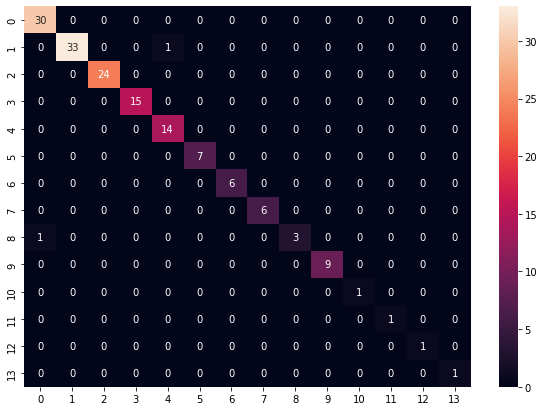

In [13]:
decision_tree = DecisionTreeClassifier(labelCol='indexedLabel', featuresCol='features', maxDepth=20)

accuracy, precision, recall, cnf_matrix = run_model(decision_tree)
print_result(accuracy, precision, recall, cnf_matrix)

# Naive bayes

21/12/10 18:29:33 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
21/12/10 18:29:33 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


result on test data
accuracy: 0.35947712418300654
precision: 0.4052542040606832
recall: 0.3594771241830066


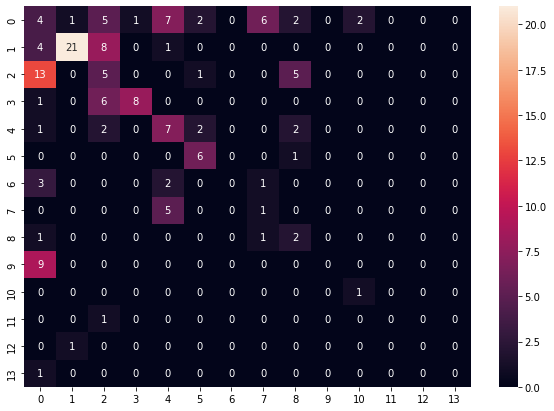

In [14]:
naive_bayes = NaiveBayes(labelCol='indexedLabel', featuresCol='features', smoothing=1.0, modelType="multinomial")
accuracy, precision, recall, cnf_matrix = run_model(naive_bayes)
print_result(accuracy, precision, recall, cnf_matrix)

# Random Forest

result on test data
accuracy: 0.9934640522875817
precision: 0.9938997821350761
recall: 0.9934640522875816


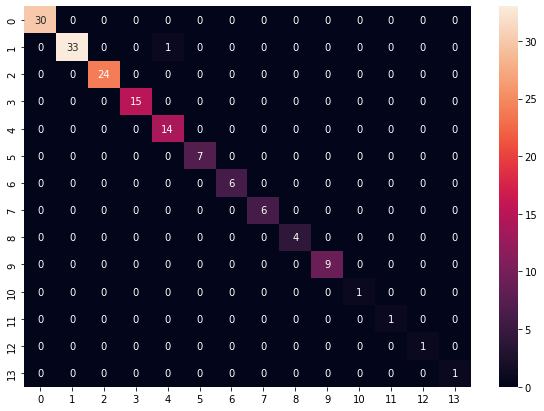

In [15]:
random_forest = RandomForestClassifier(labelCol='indexedLabel', maxDepth=20, numTrees=10)
accuracy, precision, recall, cnf_matrix = run_model(random_forest)
print_result(accuracy, precision, recall, cnf_matrix)
